# Vehicle Detection and Tracking
Detect vehicles and track their position on the road in a test video using python, state vector machines, and openCV2
## Author: Aneeq Mahmood
### Email: aneeq.sdc@gmail.com

# Cell 0: Import main modules

In [54]:
# import modules to be used 
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from scipy.ndimage.measurements import label
from random import shuffle
import os
import pickle
from skimage.feature import hog
import collections
import itertools
print("Import finished")

Import finished


## Cell 1: Helper to read images from directories

In [55]:

def dataset_read( v_dir, nv_dir,veh, nveh):
    """
    Function to read images of vehicles and non-vehicles, and saving them in a dictionary
    Inputs
    v_dir: directory path for vehicle images
    nv_dir: directory path to non-vehicles images
    veh: sub folders  list for vehicles
    nveh: list containing subfolders for non-vehicle images
    
    Output
    image_dic: dictionary of vehicles and non-vehicle images
    """
    image_dic = {}
    key1 = "vehicles"
    key2 = "non_vehicles"
    image_dic[key1] = list()
    image_dic[key2] = list()
    downsample = 5                   # downsample by this number for timeseries  images
    
     # First read non-vehicle images
    for non_vehicles in nveh:
        #iterate through non-vehicles subdirectories  
        img_mask = nv_dir + non_vehicles +'*.png'
        img_names = glob(img_mask)
        
        for img in img_names:           # read images from glob an save in dict
            
            im = cv2.imread(img)        # use cv2 to read so that image values are between 0 and 255
            image_dic[key2].append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))   # change colorspace and save in images
    
    # Iterating through vehicles subfolders    
    for vehicles in veh:
        #iterate through non-vehicles subdirectories  
        img_mask = v_dir + vehicles +'*.png'
        img_names = glob(img_mask)
    
        for ind, img in enumerate(img_names):     # read images from glob an save in dict
            
            if ( "KTTI" in vehicles ):             # Read all images rom KTTI
                im = cv2.imread(img)               # use cv2 to read so that image values are between 0 and 255
                image_dic[key1].append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))   # change colorspace and save in images
            else:                                  # read every 5th image  for GTT
                if (not ind % downsample):
                    im = cv2.imread(img)       
                    image_dic[key1].append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))  

    # Making sure that all dictionary keys have same length of values                

    differ = abs(len(image_dic["vehicles"] ) - len(image_dic["non_vehicles"] ))

    # non-vehicles has bigger size 
    temp = image_dic["non_vehicles"]
   
    # Shuffle the non-vehicle images
    shuffle(temp)
    # Cut down the number of non-vehicles images
    temp[:differ] = []


    image_dic["non_vehicles"] = temp
    
    
    
    return image_dic
    
    

# Cell 1a: Import training dataset

Making new image dictionary
Total vehicles images read are 1760 Size of each image is  (64, 64, 3)
Total non-vehicles images read are 1760 Size of each image is  (64, 64, 3)


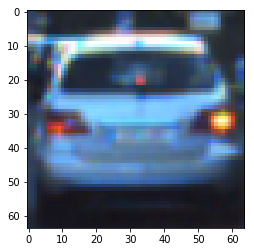

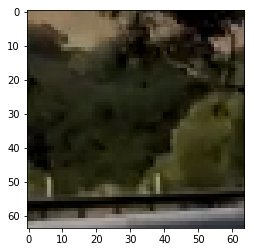

In [56]:


# IF images are already sorted and available, then use them
if os.path.exists("image_dict.p"):
    print("Using images already provided in a dictionary")
    with open('image_dict.p', 'rb') as fp:
        image_dict = pickle.load(fp)
    
else: # read images from directory "image_bank"
    print("Making new image dictionary")
    
    #Specifying folders and subfolders for entire data set
    vehicles_dir = "image_bank/vehicles/"
    n_vehicles_dir = "image_bank/non-vehicles/"
    vehicles = ["GTI_Far/","GTI_Left/","GTI_MiddleClose/","GTI_Right/", "KITTI_extracted/"]
    non_vehicles = ["Extras/","GTI/"] 
    
    image_dict = {}
    image_dict = dataset_read(vehicles_dir, n_vehicles_dir, vehicles, non_vehicles)
    

    with open('image_dict.p', 'wb') as fp:
        pickle.dump(image_dict, fp)
    
print("Total vehicles images read are", len(image_dict["vehicles"]), "Size of each image is ", np.shape(image_dict["vehicles"][-1]))
print("Total non-vehicles images read are", len(image_dict["non_vehicles"]), "Size of each image is ", np.shape(image_dict["non_vehicles"][-1]) )

# Get random images of each type for plotting

rand_car = image_dict["vehicles"][np.random.randint(len(image_dict["vehicles"]))]

rand_ncar = image_dict["non_vehicles"][np.random.randint(len(image_dict["non_vehicles"]))]
    
    
plt.figure()
plt.imshow(rand_car)  
plt.savefig("output_images/test_car.jpg")
plt.figure()
plt.imshow(rand_ncar) 
plt.savefig("output_images/test_ncar.jpg")
plt.show()


    

# Cell 2: Extract Feature Pipeline
This cell contain all feature extraction techniques  namely, spatial features (resized images), color features (from histogram), all hog features. These methods are obtained from code from tutorials and quizes in class.

In [57]:

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=64, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features



# Extract features from a list of images    
def all_img_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    features = []   
    # Obtain feature from every image in list, imgs
    for img in imgs:

        img_features = []        # a list to combine all types of features
        spatial_features = []    # list to save spatial features
        hist_features = []       # list to save histogram features
        hogg = []                # list to save hogg features
        
        #2) Apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)      
        #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)

        #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            

        #7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':         # Use all 3 channels
               # hogg = []  
                for channel in range(feature_image.shape[2]):
                    hogg.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
                hogg = np.ravel(hogg)  
            else:
                hogg.append( get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True))

           # Collect all features for one images
            img_features.append(np.concatenate((spatial_features,hist_features,hogg)))


            # Save these in a different array
    
            features.append(img_features)
 
    return features

# Extract features from a single images 

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)




# Cell 3: Get Dataset and set feature parameters

In [58]:
# Combine car and non-car images in one array
car_images = image_dict["vehicles"] + image_dict["non_vehicles"]
# Get  labels for car_images as 1 and 0
labels =    np.hstack((np.ones(len(image_dict["vehicles"])), np.zeros(len(image_dict["non_vehicles"]))))


print(len(labels), np.shape(car_images))


color_space = "YUV" # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


3520 (3520, 64, 64, 3)


# Cell 3a: Plot test outputs for hog features

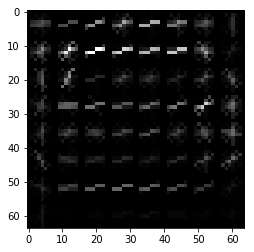

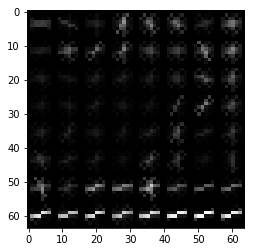

In [59]:
_, hog_img_1 = get_hog_features(cv2.cvtColor(rand_car, cv2.COLOR_RGB2GRAY),
                              orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

_, hog_img_2 = get_hog_features(cv2.cvtColor(rand_ncar, cv2.COLOR_RGB2GRAY),
                              orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)


plt.figure()
plt.imshow(hog_img_1,cmap= "gray")
plt.savefig("output_images/hogged_test_ncar.jpg")

plt.figure()
plt.imshow(hog_img_2, cmap= "gray")
plt.savefig("output_images/hogged_test_ncar.jpg")
plt.show()

#  Cell 4: Extract Features from image dataset

In [60]:
# Get a feature array for all training images
features = all_img_features(car_images, color_space, 
                            spatial_size, hist_bins, 
                            orient, pix_per_cell, 
                            cell_per_block, 
                            hog_channel,
                             spatial_feat, hist_feat, hog_feat)

sh = np.shape(features)

X = np.reshape(features,(sh[0],sh[2])).astype(np.float64)
print(X.shape)
del features

(3520, 8556)


# Cell 5: Import State vector machine (SVM)
import SVM and normalise the data by removing mean and diving by standard deviation

In [61]:
from sklearn.svm import SVC
import time
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Cell 6: Train the SVM with data

In [62]:

import pickle

# If model already trained, use this
if os.path.exists("model.p"):
    print("Using existing model")
    with open('model.p', 'rb') as fp:
            clf = pickle.load(fp)
else:

    
    rand_state = np.random.randint(0, 100)
    # Split the dataset in test and train set
    X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, labels, test_size=0.2, random_state=rand_state)

    #Build out classifier
    clf=SVC(C = 10, kernel='rbf')


    t = time.time()

    clf.fit(X_train,Y_train)  # do fitting on training data

    t2 = time.time()

    print(round(t2-t, 2), 'Seconds to train SVC...')
    #predict 
    pred=clf.predict(X_test)   # Check result on test data

    #accuaracy score
    acc=accuracy_score(pred,Y_test)
    print(acc) #returns 1.0
    # Save the model for future use
    with open('model.p', 'wb') as fp:
            pickle.dump(clf, fp)

24.46 Seconds to train SVC...
0.995738636364


# Cell 7: Get test images from test directory using glob

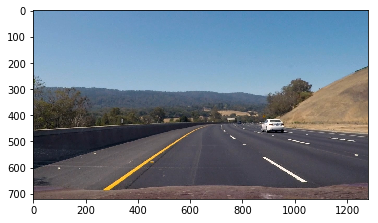

In [73]:
test_dir = "test_images/"

mask = test_dir + '*.jpg'
img_names = glob(mask)                   # Collect image names   

test_images = []
for fn in img_names:

    img = cv2.imread(fn)
    test_images.append(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))   # change colorspace and save in images

# PLot a random image
plt.imshow(test_images[np.random.randint(len(test_images))])
plt.show()

# Cell 8: Helping functions for sliding windows across and image

In [64]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    A function to draw boxes on top of images
    Inputs
    img: input images
    bboxes: list of lists with coordinates of bounding boxes
    color: color assigned to the bbox
    thick: thickness of the line
    """
    # Make a copy of the image
    imcopy = np.copy(img)
    # go through the list of lists
    for item in itertools.chain(bboxes):
        # Draw a rectangle given bbox coordinates
        for bbox in item:  # Iterate through the bounding boxes
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    

    
from sklearn.preprocessing import StandardScaler


def search_windows(img, windows, clf, scaler,  color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    """
    Scan over an area of an image, defined by windows, and looks for car in those windows
    Returns:
    
    coordinates of bounding boxes containing cars
    """
    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:

        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        feat = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        features = np.reshape(feat, (1,-1))
        #scaler = StandardScaler().fit(features)
        test_features = scaler.transform(np.array(features))

        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
      
    #8) Return windows for positive detections
    return on_windows
    
        
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
    Get coordinates of boxes after sliding boxes on an images
    Inputs
    x_start_stop: Start and end coordinates of  x-axis 
    y_start_stop= Start and end coordinates of  y-axis 
    xy_window= Tuple of window size in pixels,
    xy_overlap= Tuple of overlap between new and old windows
    
    Outputs:
    window_list: list of bounding boxes for a particular window size
    """
    
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = np.abs((x_start_stop[1] - x_start_stop[0]))
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            endx = x_start_stop[0] - xs*nx_pix_per_step  # Start from left most pixels 
            startx = endx -  xy_window[0]# calculate starting point with respect to end point
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Cell 9: Draw windows on image of different scales

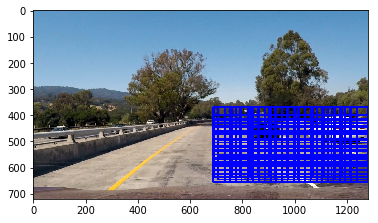

In [74]:
win_size = [  64, 100, 128 ] # Sample Window sizes/scales in pixels
windows = []

# Get a list of lists called windows, which contain windows of different sizes
for size in win_size:
    windows.append( slide_window(test_images[0], x_start_stop=[1280, 650], y_start_stop=[370,660], 
                    xy_window=(size,int(0.7*size)),xy_overlap=(0.3, 0.3))  )

# Get a random image
test_samp = test_images[np.random.randint(len(test_images))]
# Draw windows on that image, highlighting search area
window_img = draw_boxes(test_samp, windows, color=(0, 0, 255), thick=6)                    


plt.imshow(window_img)
plt.savefig("output_images/sliding_windows.jpg")
plt.show()



# Cell 10: Search for cars in highlighted area

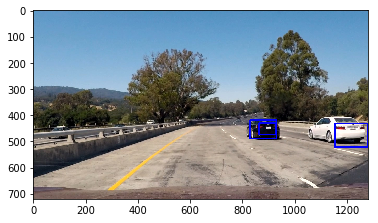

In [75]:
draw_image = np.copy(test_samp)
hot_windows = []
# go through windows of different sizes and look for cars within
for window in itertools.chain(windows):
    hot_windows.append(search_windows(draw_image, window, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))

# Draw boxes over the input image where cars are detected
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.savefig("output_images/car_detect.jpg")
plt.show()

# Cell 11: Helper functions to draw heatmaps

In [67]:


def add_heat(heatmap, bbox_list):
    """
    Highlight the area marked by boxes
    Input:
    heatmap: an image of all zeros
    bbox_list: bounding boxes 
    Output: 
    heatmap: image with non-zeros entries at bounding boxes' coordinates
    """
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    """
    Filter and remove heatmap for values less than threshold
    Input:
    heatmap: image with integer values at specific points 
    threshold: Limit
    Output:
    heatmap: original images after filtering
    """
    
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    """
    Draw labeled boxes where cars have been detected
    
    INputs
    img: input image
    labels: areas of concentrated heatmpas (see: scipy.ndimage.measurements --> label)
    Outputs: 
    img: image with bounding boxes around cars
    
    """
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



def draw_filteredlabeled_bboxes(img, labels):
    
    """
    Same as draw_labeled_bboxes() but with extra filtering
    INputs
    img: input image
    labels: areas of concentrated heatmpas (see: scipy.ndimage.measurements --> label)
    Outputs: 
    img: image with bounding boxes around cars
    
    """
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        # Remove 3 sigma outliers on x and y values 
        nonzeroy = remove_outliers(np.array(nonzero[0]))
        nonzerox = remove_outliers(np.array(nonzero[1]))
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


def remove_outliers(elements):
    """
    Remove 3 sigma outliers on np array
    INput:
    elements: Input array
    Output:
    final_list: array without 3 sigma outliers
    """
    mean = np.mean(elements, axis=0)
    sd = np.std(elements, axis=0)

    final_list = [x for x in elements if (x > mean - 3 * sd)]
    final_list = [x for x in final_list if (x < mean + 3 * sd)]
    
    return final_list







# Cell 12: Draw heat maps on an image

(720, 1280)


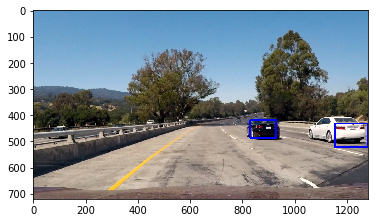

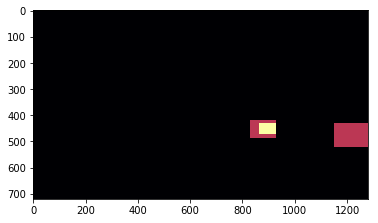

In [76]:


heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)
box_list = sum(hot_windows, [])

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,0)
print(np.shape(heat))
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
raw_img = draw_labeled_bboxes(np.copy(draw_image), labels)

# Plotting images
plt.imshow(raw_img)
plt.figure()
plt.imshow(heatmap,cmap="inferno")
plt.savefig("output_images/heat_map.jpg")

plt.show()


# Cell 13: Prepare ring buffer to save previous heatmap images

In [69]:
# Arrange deque to save heat maps
import collections

#get the frames per second for the test video

video = cv2.VideoCapture("project_video.mp4")
fps = video.get(cv2.CAP_PROP_FPS)
print(fps)
# The above API chanegs with versions so do an error check
if (0 == fps):
    fps = 25.0
all_heatmaps = collections.deque(maxlen= int(fps))
print(all_heatmaps.maxlen)



25.0
25


# Cell 14: Final Pipeline to collect images

In [70]:
def pipeline(image):
    
    """
    Main pipeline to be fed with an images
    
    Inputs: 
    image: input image
    
    Output: 
    raw_img: An image with bounded boxes around cars within that image
    """
    # Choose the the size of scaling windows in pixels   
    win_size = [  64, 100, 128 ,160, 200]
    windows = []    # save all windows here
    
    # slide the window over the useful section of the picture
    for size in win_size:
        windows.append( slide_window(image, x_start_stop=[1280, 650], y_start_stop=[370,660], 
                        xy_window=(size,int(0.7*size)),xy_overlap=(0.7, 0.7))  )
    
    # Search for cars in the windows,  using search_window() and create features within
    hot_windows = []
    for window in itertools.chain(windows):
        hot_windows.append(search_windows(image, window, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))
   
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Linearize box lists which is before a list of lists
    box_list = sum(hot_windows, [])

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)
    
    #  clip heat map and append    
    heatmap_temp = np.clip(heat, 0, 255)
    
    # Throw this heatmap in the deque
    all_heatmaps.append(heatmap_temp)
   
    # if deque already full, get average vallue
    if (len(all_heatmaps) == all_heatmaps.maxlen):

        heatmap = np.mean(all_heatmaps,axis = 0)
        
    else: #use the last obtained value
        heatmap = heatmap_temp       

        
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    # draw boxes using filered labels
    raw_img = draw_filteredlabeled_bboxes(np.copy(image), labels)
    
    return raw_img


# Cell 15: Verify pipeline

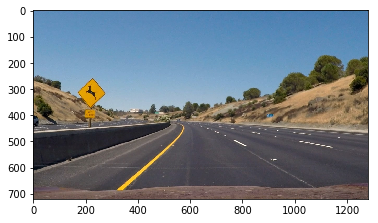

In [71]:
plt.figure()
plt.imshow(pipeline(draw_image))
plt.savefig("output_images/output_pipeline.jpg")
plt.show()


# Cell 16: Create Movie

In [72]:
from moviepy.editor import VideoFileClip


# output video name
file_output = 'output.mp4'
# read test video
clip2 = VideoFileClip('project_video.mp4')#.subclip(0,1)

# Read images into pipeline
output_clip = clip2.fl_image(pipeline)

#write to output video file   
output_clip.write_videofile(file_output, audio=False)
         

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


 96%|████████████████████████████████████████▍ | 25/26 [05:47<00:14, 14.58s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

